# Getting the most solar power for your dollar
## Exploratory Data Analysis
### Zachary Brown

The data has been cleaned and preliminary analysis has identified some trends we should expect to see the eventual model pick up on. Now I'm going to preprocess the data so that any models I work with can use the data appropriately. This will include imputing missing data, feature engineering, scaling, and splitting the data into testing and training datasets.

I'll start by loading the necessary packages and reading in the data from the exploratory data analysis portion of the project.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook')
import scipy.stats
from sklearn.model_selection import train_test_split

In [2]:
print(os.getcwd())
os.chdir(r"..\data\processed")
print(os.getcwd())

C:\Users\Zachary Brown\Documents\GitHub\Solar-Panel-Capstone\notebooks
C:\Users\Zachary Brown\Documents\GitHub\Solar-Panel-Capstone\data\processed


In [3]:
data = pd.read_csv('processed_data.csv', index_col=0, low_memory=False)
data.shape

(208257, 57)

In [4]:
data.columns.groupby(data.dtypes)

{int64: ['expansion_system', 'multiple_phase_system', 'tracking', 'ground_mounted', 'third_party_owned', 'self_installed', 'module_quantity_1', 'additional_modules', 'bipv_module_1', 'bifacial_module_1', 'additional_inverters', 'micro_inverter_1', 'solar_storage_hybrid_inverter_1', 'built_in_meter_inverter_1', 'dc_optimizer', 'year', 'month', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD', 'state_MN', 'state_NH', 'state_NM', 'state_NY', 'state_RI', 'state_TX', 'state_UT', 'state_WI'], float64: ['system_size_dc', 'total_installed_price', 'rebate_or_grant', 'azimuth_1', 'tilt_1', 'nameplate_capacity_module_1', 'efficiency_module_1', 'inverter_quantity_1', 'inverter_loading_ratio', 'price_per_kw'], object: ['data_provider_1', 'system_id_1', 'installation_date', 'customer_segment', 'zip_code', 'city', 'utility_service_territory', 'installer_name', 'module_manufacturer_1', 'module_model_1', 'technology_module_1', 'inverter_manufacturer_1', 'in

Since I only broke out month and year of the battery installation for the non-null dataframe in the last notebook, I'll create those columns in this dataframe so we can work with that data. I'll then have to impute the missing values.

In [5]:
data['date_of_battery_install'] = pd.to_datetime(data['date_of_battery_install'])

Although I removed columns with high percentages of missing data, I only checked for -1, not nulls. I'm going to recheck this column before going any further to make sure I have enough data to work with this feature.

In [6]:
data['date_of_battery_install'].isnull().sum()
print((data['date_of_battery_install'].isnull().sum()/len(data['date_of_battery_install']))*100,\
      '% of values in battery installation date are null')

93.65063359214815 % of values in battery installation date are null


Ok, unfortunately this column is over 90% missing, so it won't be much help in my modeling. I'll recheck the rest of the features to make sure there are no others I've missed.

In [7]:
percent_missing = data.isnull().sum()/len(data)*100
percent_missing.sort_values(ascending=False)

date_of_battery_install            93.650634
nameplate_capacity_module_1         0.193511
inverter_quantity_1                 0.000480
state_CA                            0.000000
additional_inverters                0.000000
micro_inverter_1                    0.000000
solar_storage_hybrid_inverter_1     0.000000
built_in_meter_inverter_1           0.000000
dc_optimizer                        0.000000
inverter_loading_ratio              0.000000
year                                0.000000
month                               0.000000
price_per_kw                        0.000000
state_AZ                            0.000000
data_provider_1                     0.000000
inverter_model_1                    0.000000
state_CT                            0.000000
state_DE                            0.000000
state_FL                            0.000000
state_MA                            0.000000
state_MD                            0.000000
state_MN                            0.000000
state_NH  

Alright, so that's the only one that needs to be removed due to null values. Since I'm only delving into the state level, not any smaller, I'm going to remove the city and zip code columns as well. The rest I'll just need to adjust for modeling.

In [8]:
data=data.drop(columns=['date_of_battery_install', 'zip_code', 'city'])

Next I want to browse the object columns and count how many unique values each has. If a feature has too many unique values they won't help identify any trends.

In [9]:
for col in data.columns:
    if data[col].dtypes == 'object':
        print(col, ' : ', data[col].nunique())

data_provider_1  :  22
system_id_1  :  200023
installation_date  :  530
customer_segment  :  1
utility_service_territory  :  72
installer_name  :  2641
module_manufacturer_1  :  157
module_model_1  :  2460
technology_module_1  :  7
inverter_manufacturer_1  :  64
inverter_model_1  :  629


Based on these results it should be safe to remove system_id_1, as that has a unique value for almost every entry. I'll also drop customer_segment since earlier in the project I limited the dataset to only residential installations. 

In [10]:
data = data.drop(columns=['system_id_1', 'customer_segment'])

Great! Now I need to encode these categorical features as I did with the states earlier. To do so I'll check the number of entries for each unique value for any feature with more than 30 unique values (anything below 30 I'll just dummy encode like I did with states). If certain values appear in more than 10% of the entries then I'll check to see if they correlate with price per KW when compared against all other values for that feature.

In [11]:
data = pd.get_dummies(data, columns=['technology_module_1', 'data_provider_1'])
data.shape

(208257, 79)

In [12]:
cols = ['installation_date', 'utility_service_territory', 'installer_name', 'module_manufacturer_1',\
        'module_model_1', 'inverter_manufacturer_1', 'inverter_model_1']
for col in cols:
    print(col, ':\n', data[col].value_counts(normalize=True).loc[lambda x : x>0.1], '\n')

installation_date :
 Series([], Name: installation_date, dtype: float64) 

utility_service_territory :
 Pacific Gas and Electric      0.325833
Southern California Edison    0.227815
San Diego Gas and Electric    0.129974
Name: utility_service_territory, dtype: float64 

installer_name :
 Series([], Name: installer_name, dtype: float64) 

module_manufacturer_1 :
 Hanwha Q CELLS    0.221428
SunPower          0.127386
-1                0.106056
LG Electronics    0.101082
Name: module_manufacturer_1, dtype: float64 

module_model_1 :
 -1    0.106056
Name: module_model_1, dtype: float64 

inverter_manufacturer_1 :
 SolarEdge Technologies    0.407410
Enphase Energy            0.250974
-1                        0.116222
SunPower                  0.104832
Name: inverter_manufacturer_1, dtype: float64 

inverter_model_1 :
 -1                    0.116217
IQ7-60-2-US [240V]    0.114162
SE3800H-US [240V]     0.107295
Name: inverter_model_1, dtype: float64 



Based on these distributions I'm going to drop installation_date and installer_name since none of their values account for 10% or more of the entries in the dataset. For the values that do account for at least 10% of the data I'll perform t-tests comparing the price_per_kw for entries with that value vs the rest of the entries. If the p-value of the t-test is less than 0.01 then I'll create a dummy column for it. This includes treating missing data as its own value, since there could be a correlation there as well.

In [13]:
data = data.drop(columns=['installation_date', 'installer_name'])

In [14]:
# Utility service territory: Pacific Gas and Electric
pge = data[data['utility_service_territory'] == 'Pacific Gas and Electric']
not_pge = data[data['utility_service_territory'] != 'Pacific Gas and Electric']
print(scipy.stats.ttest_ind(pge['price_per_kw'], not_pge['price_per_kw']))

Ttest_indResult(statistic=11.85801565604619, pvalue=2.0031706292799543e-32)


In [15]:
data['territory_pacific_gas_and_electric'] = (data['utility_service_territory'] == 'Pacific Gas and Electric')*1

In [16]:
# Utility service territory: Southern California Edison
sce = data[data['utility_service_territory'] == 'Southern California Edison']
not_sce = data[data['utility_service_territory'] != 'Southern California Edison']
print(scipy.stats.ttest_ind(sce['price_per_kw'], not_sce['price_per_kw']))

Ttest_indResult(statistic=-2.2723086588535213, pvalue=0.02306888894162181)


In [17]:
# Utility service territory: San Diego Gas and Electric
sdge = data[data['utility_service_territory'] == 'San Diego Gas and Electric']
not_sdge = data[data['utility_service_territory'] != 'San Diego Gas and Electric']
print(scipy.stats.ttest_ind(sdge['price_per_kw'], not_sdge['price_per_kw']))

Ttest_indResult(statistic=5.735900280612528, pvalue=9.712940594647251e-09)


At this point I'm going to make a copy of the dataframe as a bookmark preceding any data imputation or data loss. My next step will impute missing data as an 'other' category, and after initial modeling I may want to jump back to before this step to rework how I handle those missing data.

In [ ]:
no_imputation = data.copy()
no_imputation.to_csv('pre-imputation preprocessing data.csv')

In [18]:
data['territory_san_diego_gas_and_electric'] = (data['utility_service_territory'] == 'San Diego Gas and Electric')*1
data['utility_service_territory_other'] = (~data['utility_service_territory'].isin(['Pacific Gas and Electric',\
                                                                                     'San Diego Gas and Electric']))*1
data=data.drop(columns=['utility_service_territory'])

In [19]:
# Module manufacturer 1: Hanwha Q CELLS
hqc = data[data['module_manufacturer_1'] == 'Hanwha Q CELLS']
not_hqc = data[data['module_manufacturer_1'] != 'Hanwha Q CELLS']
print(scipy.stats.ttest_ind(hqc['price_per_kw'], not_hqc['price_per_kw']))

Ttest_indResult(statistic=-8.214259356889922, pvalue=2.1468194935052494e-16)


In [20]:
data['hanwha_q_cells'] = (data['module_manufacturer_1'] == 'Hanwha Q CELLS')*1

In [21]:
# Module manufacturer 1: SunPower
sp = data[data['module_manufacturer_1'] == 'SunPower']
not_sp = data[data['module_manufacturer_1'] != 'SunPower']
print(scipy.stats.ttest_ind(sp['price_per_kw'], not_sp['price_per_kw']))

Ttest_indResult(statistic=8.007335978228957, pvalue=1.1781773887289662e-15)


In [22]:
data['sunpower'] = (data['module_manufacturer_1'] == 'SunPower')*1

In [23]:
# Module manufacturer 1: Missing
missing = data[data['module_manufacturer_1'] == '-1']
not_missing = data[data['module_manufacturer_1'] != '-1']
print(scipy.stats.ttest_ind(missing['price_per_kw'], not_missing['price_per_kw']))

Ttest_indResult(statistic=-6.506949323277298, pvalue=7.686520594864674e-11)


In [24]:
data['module_manufacturer_1_missing'] = (data['module_manufacturer_1'] == '-1')*1

In [25]:
# Module manufacturer 1: LG Electronics
lg = data[data['module_manufacturer_1'] == 'LG Electronics']
not_lg = data[data['module_manufacturer_1'] != 'LG Electronics']
print(scipy.stats.ttest_ind(lg['price_per_kw'], not_lg['price_per_kw']))

Ttest_indResult(statistic=-5.823115696649686, pvalue=5.784496402514569e-09)


In [26]:
data['lg_electronics'] = (data['module_manufacturer_1'] == 'LG Electronics')*1
data['module_manufacturer_1_other'] = (~data['module_manufacturer_1'].isin(['Hanwha Q CELLS',\
                                                                                     'SunPower', 'LG Electronics', '-1']))*1
data=data.drop(columns=['module_manufacturer_1'])

In [27]:
# Module model 1: missing values
missing = data[data['module_model_1'] == '-1']
not_missing = data[data['module_model_1'] != '-1']
print(scipy.stats.ttest_ind(missing['price_per_kw'], not_missing['price_per_kw']))

Ttest_indResult(statistic=-6.506949323277298, pvalue=7.686520594864674e-11)


In [28]:
data['module_model_1_missing'] = (data['module_model_1'] == '-1')*1
data['module_model_1_not_missing'] = (data['module_model_1'] != '-1')*1
data = data.drop(columns=['module_model_1'])

In [29]:
# Inverter manufacturer 1: SolarEdge Technologies
se = data[data['inverter_manufacturer_1'] == 'SolarEdge Technologies']
not_se = data[data['inverter_manufacturer_1'] != 'SolarEdge Technologies']
print(scipy.stats.ttest_ind(se['price_per_kw'], not_se['price_per_kw']))

Ttest_indResult(statistic=10.969445074840884, pvalue=5.455545867730912e-28)


In [30]:
data['solaredge_technologies'] = (data['inverter_manufacturer_1'] == 'SolarEdge Technologies')*1

In [31]:
# Inverter manufacturer 1: Enphase Energy
ee = data[data['inverter_manufacturer_1'] == 'Enphase Energy']
not_ee = data[data['inverter_manufacturer_1'] != 'Enphase Energy']
print(scipy.stats.ttest_ind(ee['price_per_kw'], not_ee['price_per_kw']))

Ttest_indResult(statistic=-10.706508488203717, pvalue=9.640694231025681e-27)


In [32]:
data['enphase_energy'] = (data['inverter_manufacturer_1'] == 'Enphase Energy')*1

In [33]:
# Inverter manufacturer 1: Missing
missing = data[data['inverter_manufacturer_1'] == '-1']
not_missing = data[data['inverter_manufacturer_1'] != '-1']
print(scipy.stats.ttest_ind(missing['price_per_kw'], not_missing['price_per_kw']))

Ttest_indResult(statistic=-7.509683112556665, pvalue=5.950533690678373e-14)


In [34]:
data['inverter_manufacturer_1_missing'] = (data['inverter_manufacturer_1'] == '-1')*1

In [35]:
# Inverter manufacturer 1: SunPower
sp = data[data['inverter_manufacturer_1'] == 'SunPower']
not_sp = data[data['inverter_manufacturer_1'] != 'SunPower']
print(scipy.stats.ttest_ind(sp['price_per_kw'], not_sp['price_per_kw']))

Ttest_indResult(statistic=10.464135123265264, pvalue=1.2808671552350103e-25)


In [36]:
data['sunpower'] = (data['inverter_manufacturer_1'] == 'SunPower')*1
data['inverter_manufacturer_1_other'] = (~data['inverter_manufacturer_1'].isin(['SolarEdge Technologies',\
                                                                                     'Enphase Energy', 'SunPower', '-1']))*1
data=data.drop(columns=['inverter_manufacturer_1'])

In [37]:
# Inverter model 1: Missing
missing = data[data['inverter_model_1'] == '-1']
not_missing = data[data['inverter_model_1'] != '-1']
print(scipy.stats.ttest_ind(missing['price_per_kw'], not_missing['price_per_kw']))

Ttest_indResult(statistic=-7.508676624240208, pvalue=5.996442552978743e-14)


In [38]:
data['inverter_model_1_missing'] = (data['inverter_model_1'] == '-1')*1

In [39]:
# Inverter model 1: IQ7-60-2-US [240V]
iq7 = data[data['inverter_model_1'] == 'IQ7-60-2-US [240V]']
not_iq7 = data[data['inverter_model_1'] != 'IQ7-60-2-US [240V]']
print(scipy.stats.ttest_ind(iq7['price_per_kw'], not_iq7['price_per_kw']))

Ttest_indResult(statistic=-3.284366816056643, pvalue=0.0010222865170599258)


In [40]:
data['iq7'] = (data['inverter_model_1'] == 'IQ7-60-2-US [240V]')*1

In [41]:
# Inverter model 1: SE3800H-US [240V]
se3 = data[data['inverter_model_1'] == 'SE3800H-US [240V]']
not_se3 = data[data['inverter_model_1'] != 'SE3800H-US [240V]']
print(scipy.stats.ttest_ind(se3['price_per_kw'], not_se3['price_per_kw']))

Ttest_indResult(statistic=14.67378142946512, pvalue=1.0038492311428803e-48)


In [42]:
data['se3'] = (data['inverter_model_1'] == 'SE3800H-US [240V]')*1
data['inverter_model_1_other'] = (~data['inverter_model_1'].isin(['IQ7-60-2-US [240V]',\
                                                                                     'SE3800H-US [240V]', '-1']))*1
data=data.drop(columns=['inverter_model_1'])

In [45]:
print(data.columns.groupby(data.dtypes))

print(data.shape)

{uint8: ['technology_module_1_-1', 'technology_module_1_CIGS', 'technology_module_1_CdTe', 'technology_module_1_Mono', 'technology_module_1_Multi-c-Si', 'technology_module_1_Poly', 'technology_module_1_Thin Film', 'data_provider_1_Arizona Public Service', 'data_provider_1_Austin Energy', 'data_provider_1_CPS Energy', 'data_provider_1_California Public Utilities Commission', 'data_provider_1_Connecticut Green Bank', 'data_provider_1_Delaware Department of Natural Resources and Environmental Control', 'data_provider_1_Frontier Associates', 'data_provider_1_Gainesville Regional Utilities', 'data_provider_1_Los Angeles Department of Water & Power', 'data_provider_1_MA DOER', 'data_provider_1_Maryland Energy Administration', 'data_provider_1_Mohave Electric Cooperative', 'data_provider_1_New Hampshire Public Utilities Commission', 'data_provider_1_New York State Energy Research and Development Authority', 'data_provider_1_Orlando Utilities Commission', 'data_provider_1_Rhode Island Commerce

Great! All of the non-numeric features have been converted into dummy features or dropped. 

## It's important to note that for utility service territory I've imputed the missing values as 'other'. This may need to be adjusted later on as I work through modeling.

Now the rest of the data imputation and scaling needs to be performed on the training dataset, then applied to the test dataset, so now that all of the desired features have been created I'll split the data into test and train sets. The last thing I'll do before that is replace any remaining NaNs with -1 so that I only have one indicator for missing data.

In [79]:
data = data.fillna(-1)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(data, data['price_per_kw'], test_size=0.25)

In [81]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(156192, 90) (52065, 90) (156192,) (52065,)


Now I need to check the numeric columns to see if they have -1 for missing data, then decide how best to replace those for the modeling.

In [82]:
for col in X_train.columns:
    if (X_train[col] == -1).sum() != 0:
        print(col, ' : ', (X_train[col] == -1).sum())

tracking  :  34366
ground_mounted  :  43339
third_party_owned  :  11404
self_installed  :  9577
azimuth_1  :  35236
tilt_1  :  35199
module_quantity_1  :  21892
additional_modules  :  28489
bipv_module_1  :  17168
bifacial_module_1  :  16566
nameplate_capacity_module_1  :  16882
efficiency_module_1  :  18768
inverter_quantity_1  :  21940
additional_inverters  :  28489
micro_inverter_1  :  18177
solar_storage_hybrid_inverter_1  :  26633
built_in_meter_inverter_1  :  18177
dc_optimizer  :  17196
inverter_loading_ratio  :  33241


First I'll work through categorical numerical columns to check the distributions and determine how best to impute the missing values.

In [83]:
cols = ['self_installed', 'tracking', 'ground_mounted', 'third_party_owned', 'bipv_module_1', 'bifacial_module_1',\
      'additional_inverters', 'additional_modules', 'dc_optimizer', 'micro_inverter_1', 'built_in_meter_inverter_1',\
      'solar_storage_hybrid_inverter_1']
X_train[cols].apply(func = pd.Series.value_counts, args=('normalize', True))

,self_installed,tracking,ground_mounted,third_party_owned,bipv_module_1,bifacial_module_1,additional_inverters,additional_modules,dc_optimizer,micro_inverter_1,built_in_meter_inverter_1,solar_storage_hybrid_inverter_1
-1,0.061316,0.220024,0.277473,0.073013,0.109916,0.106062,0.182397,0.182397,0.110095,0.116376,0.116376,0.170514
0,0.922595,0.777018,0.709255,0.603360,0.887830,0.892568,0.817532,0.809785,0.472118,0.469640,0.474243,0.801981
1,0.016089,0.002958,0.013272,0.323627,0.002254,0.001370,0.000070,0.007817,0.417787,0.413984,0.409381,0.027505


Many of these columns are heavily skewed, so I'll impute the missing values using the mode and assign the missing values to the more heavily favored response. When I begin modeling I'll compare the model using the imputed results vs removing the columns completely to determine whether I need to reasses how to impute these missing values

In [84]:
X_train[cols] = X_train[cols].replace({-1:0})
X_test[cols] = X_test[cols].replace({-1:0})

Now that the categorical numerical features have been taken care of I'll recheck what continuous numerical variables are left to clean up.

In [85]:
cols=[]
for col in X_train.columns:
    if (X_train[col] == -1).sum() != 0:
        cols.append(col)
        print(col, ' : ', (round(X_train[col].value_counts(normalize = True).loc[-1], 2) * 100), '% missing')

azimuth_1  :  23.0 % missing
tilt_1  :  23.0 % missing
module_quantity_1  :  14.000000000000002 % missing
nameplate_capacity_module_1  :  11.0 % missing
efficiency_module_1  :  12.0 % missing
inverter_quantity_1  :  14.000000000000002 % missing
inverter_loading_ratio  :  21.0 % missing


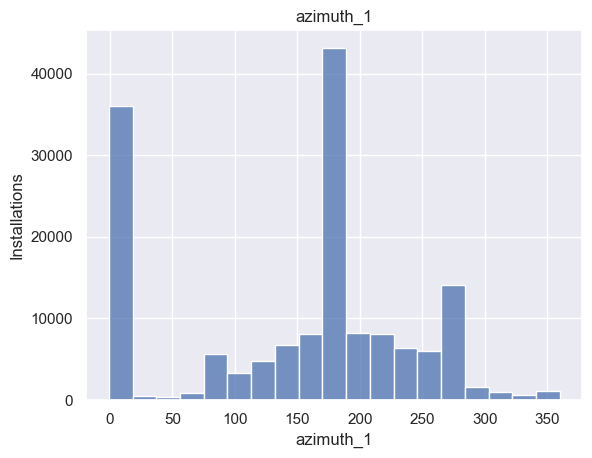

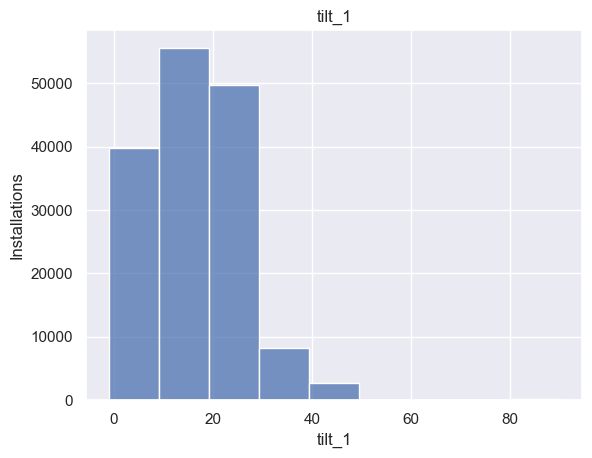

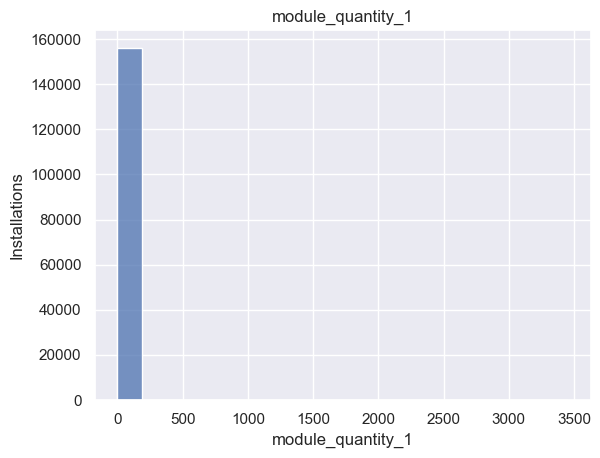

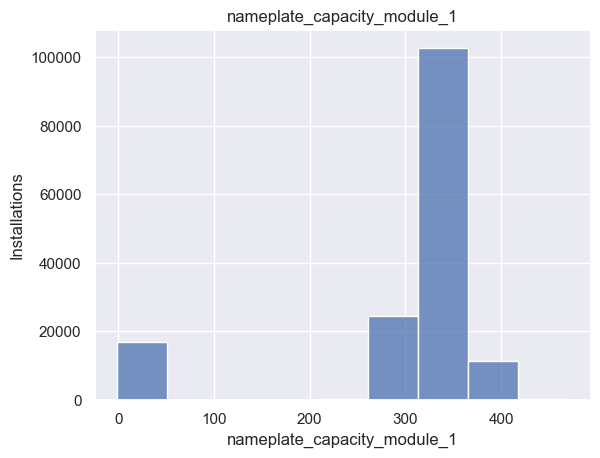

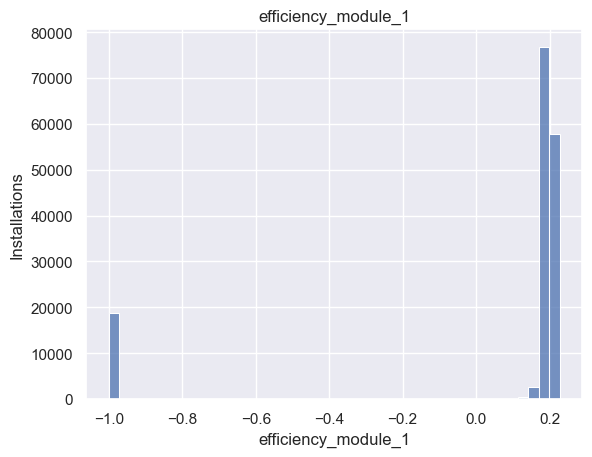

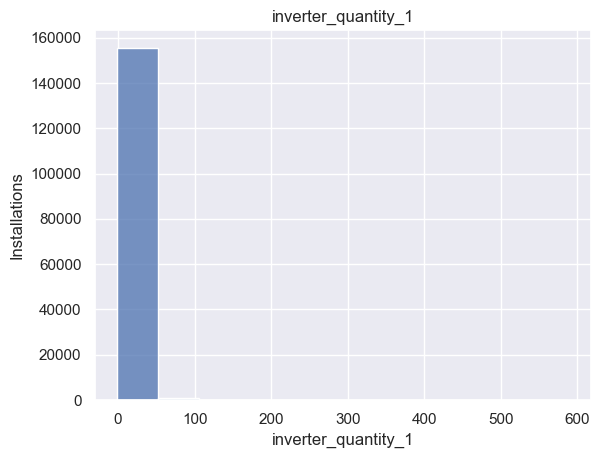

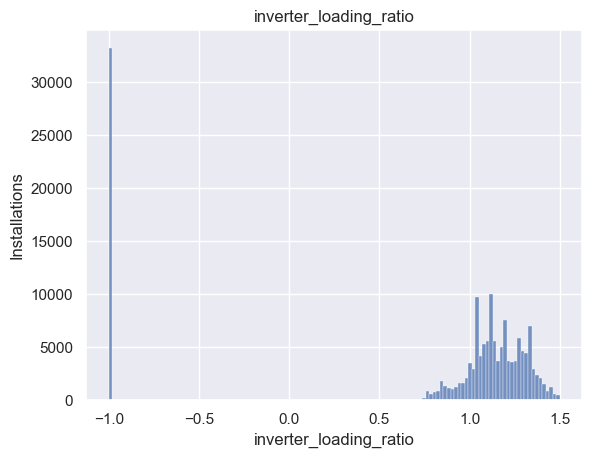

In [86]:
for col in X_train[cols]:
    bins=round(np.sqrt(len(data[col].unique())))
    sns.histplot(data=X_train[col], bins=bins)
    plt.title(col)
    plt.ylabel('Installations')
    plt.xlabel(col)
    plt.show()

Since all of these features are missing 10-25% of their values I don't want to just throw the missing values all onto either the mean or median because that will heavily skew the distributions. Instead I'll make KNN models to predict the missing data for each feature.

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

N_SPLITS = 4
regressor = RandomForestRegressor(random_state=0)
x_labels = []

def get_scores_for_imputer(imputer, X_missing, y_missing):
    estimator = make_pipeline(imputer, regressor)
    impute_scores = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )
    return impute_scores

def get_full_score(X_full, y_full):
    full_scores = cross_val_score(
        regressor, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS
    )
    return full_scores.mean(), full_scores.std()

def get_impute_knn_score(X_missing, y_missing):
    imputer = KNNImputer(missing_values=-1, add_indicator=True)
    knn_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return knn_impute_scores.mean(), knn_impute_scores.std()


for col in X_train[cols]:    
    xs, ys = X_train.drop(columns=col), X_train[col].values.ravel()
    x_labels = []

    mse_col = np.zeros(2)
    std_col = np.zeros(2)
    
    mse_col[0], std_col[0] = get_full_score(xs, ys)
    x_labels.append("Full data")

    mse_col[1], std_col[1] = get_impute_knn_score(xs, ys)                           
    x_labels.append("KNN Imputation")

In [ ]:
print(x_labels)